In [1]:
import keras
import os
import typing
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import numpy as np
import cv2
import json
from pathlib import Path

Using TensorFlow backend.


In [3]:
#import all libraries
from PIL import Image, ImageOps,ImageFilter
#import cv2
import time
import argparse
from scipy import ndimage
from scipy import misc
%matplotlib inline
import readline
readline.parse_and_bind("tab: complete")
from scipy import ndimage
from multiprocessing.pool import ThreadPool

from urllib.request import Request, urlopen, HTTPError
import ssl

In [4]:
import os
import numpy as np
import argparse
from keras.models import Model
from PIL import Image, ImageOps,ImageFilter
import matplotlib.image as mpimg
import csv
from numpy import linalg
from pandas import HDFStore

In [11]:
import os

def Get_folder_name_labels(dir_path):

    df_logos_folder = pd.DataFrame(columns=['true_logo','folder_name','folder_img_count'])
    mn = 0
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    num_folders =1

    for company_name in folders:
        contents = os.listdir(os.path.join(dir_path,company_name)) # get list of contents
        if len(contents) <= mn: # if greater than the limit, print folder and number of contents
            continue
        row = pd.Series({'true_logo' :num_folders,
                         'folder_name' :company_name,
                        'folder_img_count': len(contents),
                        'folder_path': os.path.join(dir_path,company_name),})
        print(os.path.join(dir_path,company_name))
        print("length:",str(len(contents)))
        num_folders = num_folders+1
        df_logos_folder = df_logos_folder.append(row,ignore_index=True)   
        
    
    return df_logos_folder

In [ ]:
dir_litw=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/Raw_data")
df_logos_folder_label=Get_folder_name_labels(dir_litw)
print("total folder", str(df_logos_folder_label.shape))

In [32]:
#Image processing for resizing images
def fix_aspect_ratio(img,expected_dimension):
    original_max_dim = max(float(img.size[0]),float(img.size[1]))
    original_min_dim = min(float(img.size[0]),float(img.size[1]))
    wpercent = (expected_dimension/float(original_max_dim))
    hsize = int((original_min_dim*float(wpercent)))
    new_im = img.resize((expected_dimension,hsize), Image.ANTIALIAS)
    return new_im

In [33]:
# Make square images
def make_square(img, min_size=120, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [34]:
# Sharpen the edges
from pylab import *
def sharpen_filter(img):
    sharp_im = img.filter(ImageFilter.SHARPEN)
    return sharp_im

In [ ]:

def verify_images_df(glob_path_complete, folder_name,dir_litw_resized, size_threshold,folder_label,expected_dimension):
    try:
        
         # in each folder, find image file and resize-scale them without distortion

        glob_path_complete_path =Path(os.path.join(glob_path_complete,folder_name))
    
        for filename_logo in glob_path_complete_path.glob('**/*.jpg'):
            img = Image.open(filename_logo) # open the image file
            img.verify() # verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
        print('Bad file:', filename_logo) # print out the names of corrupt files

In [ ]:
import scipy.signal
def calculate_MSCN_val(img):
    C=3.0/255.0
    blurred_img=cv2.GaussianBlur(img, (7, 7), 1.166)
    blurred_sq = blurred_img * blurred_img 
    sigma = cv2.GaussianBlur(img * img, (7, 7), 1.166) 
    sigma = (sigma - blurred_sq) ** 0.5
    sigma = sigma + C
    MCSN_value = (img - blurred_img)/sigma
    return MCSN_value

In [ ]:
# Load dataset of logos in a dataframe
def resize_images_df(folder_path_global, company_name,dir_litw_resized, expected_dimension,size_threshold, folder_logo_num):
    df_logos_pickle = pd.DataFrame(columns=['true_logo','logo_img_name','original_image_name','company_brand','mean_mean_val','mean_std_val','mscn_val'])
    
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1;
    #print(glob_path_complete) 
    glob_path_complete_path_inter=os.path.join(folder_path_global,company_name)
    glob_path_complete_path=Path(glob_path_complete_path_inter)
    mod_folder_name = 'Mod-' + str(company_name)
    mod_full_dir = os.path.join(dir_litw_resized,mod_folder_name) 
    brand_count_row=1
    for filename_logo in glob_path_complete_path.glob('**/*.jpg'):
         with open(filename_logo) as imagefile:
            if brand_count_row > 200:
                return df_logos_pickle
            image_original = Image.open(filename_logo)
            dir_name,file_orig_name = os.path.split(filename_logo)
            get_file_data_shape_x, get_file_data_shape_y = image_original.size
            max_size_dimension = max(float(get_file_data_shape_x),float(get_file_data_shape_y))
            if max_size_dimension < size_threshold:
                continue 
            img_mod_name = company_name +'-AB-'+ str(index_image) +'.png'
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name)             
            
            company_brand_name = company_name         
           

            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            norm_image=cv2.normalize(im_med,None,0,1, cv2.NORM_MINMAX)
            
            mean_values, std_values = cv2.meanStdDev(norm_image)
            mscn_values= calculate_MSCN_val(norm_image)
            mean_mean_val = np.mean(mean_values)
            mean_std_val = np.mean(std_values)
            mean_mscn_val =  np.mean(mscn_values)
            company_brand_name = company_name
            
           
           # mscn_val=calculate_MSCN_values(norm_image)

            row = pd.Series({'true_logo' :folder_logo_num,
                            'logo_img_name' :img_mod_name,
                             'original_image_name' :file_orig_name,
                             'company_brand' :company_brand_name,
                            'mean_mean_val': mean_mean_val,
                            'mean_std_val': mean_std_val,
                            'mscn_val': mean_mscn_val,})
            
            df_logos_pickle = df_logos_pickle.append(row,ignore_index=True) 
            
            brand_count_row=brand_count_row+1
            file_name=os.path.join(mod_full_dir,img_mod_name)
            misc.imsave(file_name, im_med)
            index_image =index_image+1
            
  

    return df_logos_pickle   
           
        

In [ ]:
# Prepare the logos dataset datastructure
# Set threshold for the size of the logo images to avoid heavy distortion due to resize
def get_all_images():

    dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/Raw_data")
    dir_litw_resized=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_details_v4")
    df_list=[]
    df_folder_Stat_list=[]
    folder_logo_num=0
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    for company_name in folders:
        expected_dimension=120
        size_threshold=17
        folder_path_global=dir_litw
        #verify_images_df(folder_path_global, company_name,dir_litw, size_threshold,folder_logo_num,expected_dimension)
        df_list.append(resize_images_df(folder_path_global, company_name,dir_litw_resized, expected_dimension,size_threshold,folder_logo_num))
        # print(df_list)
        #df_folder_Stat_list=df_folder_Stat_list.append([df_folder_Stat])
        
        tp_df = pd.concat(df_list, ignore_index=True)  
        #tp_df_stat=pd.concat(df_folder_Stat, ignore_index=True) 
        folder_logo_num=folder_logo_num+1
    return tp_df

In [ ]:
tp_df_image_resized=get_all_images()

#tp_df_image_resized=

In [ ]:

def get_folder_stats(df_logos_folder_label, df_folder_details):
    
    
    df_logos_folder = pd.DataFrame(columns=['company_brand','folder_mean_val','folder_std_val','folder_mscn_val']) 
    dir_path='c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_details_v4'
    folders = ([name for name in sorted(os.listdir(dir_path), key=str.casefold)]) # get all directories 
    
    for company_name in folders:
        company_name=company_name[4:len(company_name)]
        
        df_rows=df_folder_details.loc[df_folder_details['company_brand'] == company_name]
        
        mean_mean_val=df_rows["mean_mean_val"].mean() 
        mean_std_val=df_rows["mean_std_val"].mean()
        mean_mscn_val=df_rows["mscn_val"].mean() 
        row = pd.Series({'company_brand' :company_name,
                            'folder_mean_val': mean_mean_val,
                            'folder_std_val': mean_std_val,
                            'folder_mscn_val': mean_mscn_val,})
            
        df_logos_folder = df_logos_folder.append(row,ignore_index=True) 
    return df_logos_folder

In [ ]:
df_logos_folder=get_folder_stats(df_logos_folder_label,tp_df_image_resized)


In [ ]:
print(df_logos_folder.loc[df_logos_folder['company_brand']=='toyota'])
print(df_logos_folder.loc[df_logos_folder['company_brand']=='hyundai'])
print(df_logos_folder.loc[df_logos_folder['company_brand']=='huawei-symbol'])

In [ ]:
tp_df_image_resized.to_csv('folder_image_Details_6152019_v2.csv')
df_logos_folder.to_csv('folder_Stats_615209_v2.csv')

In [ ]:
tf_toyota_rows= (tp_df_image_resized.loc[tp_df_image_resized['company_brand']=='toyota'])
#print(tf_toyota_rows["folder_mscn_val"])
#print(tf_toyota_rows)
tf_toyota_rows["original_image_name"][tf_toyota_rows["mean_mean_val"] < 0.454*0.4]
tf_toyota_rows["original_image_name"][tf_toyota_rows["mean_std_val"] < 0.413*0.4]
tf_toyota_rows["original_image_name"][tf_toyota_rows["mscn_val"] < 35.17*0.1]

In [ ]:
# Load dataset of logos in a dataframe
def get_file_excluded_1(folder_path_global, company_name,dir_litw_resized, expected_dimension,size_threshold, folder_logo_num, threshold_mean,threshold_std,threshold_mscn):
    df_logos_pickle = pd.DataFrame(columns=['true_logo','logo_img_name','original_image_name','company_brand','mean_mean_val','mean_std_val','mscn_val'])
    
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1;
    #print(glob_path_complete) 
    glob_path_complete_path_inter=os.path.join(folder_path_global,company_name)
    glob_path_complete_path=Path(glob_path_complete_path_inter)
    mod_folder_name = str(company_name)
    mod_full_dir = os.path.join(dir_litw_resized,mod_folder_name) 
    brand_count_row=1
    
    for filename_logo in glob_path_complete_path.glob('**/*.png'):
         with open(filename_logo) as imagefile:
            
           
            
            image_original = Image.open(filename_logo)
            dir_name,file_orig_name = os.path.split(filename_logo)
            get_file_data_shape_x, get_file_data_shape_y = image_original.size
            max_size_dimension = max(float(get_file_data_shape_x),float(get_file_data_shape_y))
            if max_size_dimension < size_threshold:
                continue 
            
            img_mod_name = company_name +'-AB-'+ str(index_image) +'.png'
            
                        
            
            company_brand_name = company_name         
           

            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            norm_image=cv2.normalize(im_med,None,0,1, cv2.NORM_MINMAX)
            
            mean_values, std_values = cv2.meanStdDev(norm_image)
            mscn_values= calculate_MSCN_val(norm_image)
            mean_mean_val = np.mean(mean_values)
            mean_std_val = np.mean(std_values)
            mean_mscn_val =  np.mean(mscn_values)
            company_brand_name = company_name
            
            if mean_mean_val < threshold_mean or mean_std_val < threshold_std or abs(mean_mscn_val) < abs(threshold_mscn):
                continue
             
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name) 
            #mscn_val=calculate_MSCN_values(norm_image)

            row = pd.Series({'true_logo' :folder_logo_num,
                            'logo_img_name' :img_mod_name,
                             'original_image_name' :file_orig_name,
                            'mean_mean_val': mean_mean_val,
                            'mean_std_val': mean_std_val,
                            'mscn_val': mean_mscn_val,})
            
            df_logos_pickle = df_logos_pickle.append(row,ignore_index=True) 
            
           
            file_name=os.path.join(mod_full_dir,img_mod_name)
            misc.imsave(file_name, im_med)
            index_image =index_image+1
            brand_count_row=brand_count_row+1
            if brand_count_row > 10: # store 10 images
                return df_logos_pickle
                        
   
    return df_logos_pickle   
           
        

In [ ]:
def test_data_exclusion_1(df_logos_folder):
    
    dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_details_v3")
    dir_litw_resized=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_excluded_mscn5")
    df_list=[]
    df_folder_Stat_list=[]
    folder_logo_num=0
    mn=50
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    for company_name in folders:
        contents = os.listdir(os.path.join(dir_litw,company_name)) # get list of contents
        if len(contents) <= mn: # if greater than the limit, print folder and number of contents
            continue
        else:
            print(len(contents))
        company_name=company_name[4:len(company_name)] # check company name with the PD company name to retrieve stats
        pd_company_stat_row = df_logos_folder.loc[df_logos_folder["company_brand"] == company_name]
        mean_threshold=((pd_company_stat_row["folder_mean_val"]).values[0])
        stdev_threshold=((pd_company_stat_row["folder_std_val"]).values[0])
        mscn_threshold=0.8*((pd_company_stat_row["folder_mscn_val"]).values[0])
       
        expected_dimension=120
        size_threshold=17
        folder_path_global=dir_litw
        company_name= "Mod-"+str(company_name)
        #verify_images_df(folder_path_global, company_name,dir_litw, size_threshold,folder_logo_num,expected_dimension)
        df_list.append(get_file_excluded_1(folder_path_global, company_name,dir_litw_resized, expected_dimension,size_threshold, folder_logo_num, mean_threshold,stdev_threshold,mscn_threshold))
        # print(df_list)
        #df_folder_Stat_list=df_folder_Stat_list.append([df_folder_Stat])
        tp_df = pd.concat(df_list, ignore_index=True)  
        #tp_df_stat=pd.concat(df_folder_Stat, ignore_index=True) 
        folder_logo_num=folder_logo_num+1
   
    return tp_df
    

    

In [ ]:

tp_df_excluded=test_data_exclusion_1(df_logos_folder)

In [6]:
from keras.models import load_model
from joblib import dump, load
import pickle
from sklearn.cluster import KMeans

#model = load('filename_22.joblib') 
model= load('./Models_embedding/filename_6272019_v1_search.joblib')
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[

In [7]:
def Store_Image_Features_files(glob_path_complete_path,intermediate_layer_model,company_brand_name,folder_logo_num,query_feature):
    
    df_feature_file_rows = pd.DataFrame(columns=['true_logo','logo_img_name','company_brand','features_list'])
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    
    file_name= (os.listdir(glob_path_complete_path))
    
    
    index = 0
   
    record_file_rows=[]
    features_img_rows=[]
    imageID=1
    score_folder=0
    for record_file in file_name:
        X_train_row =[]
        file_name_full=os.path.join(glob_path_complete_path,record_file)
        logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
        img_original = mpimg.imread(file_name_full)
        if imageID > 4:
            continue
        normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
        logo_imgs_stage[0] = normalizedImg[:,:,:3]
        X_train_row.append(logo_imgs_stage)
        X_train=np.concatenate(X_train_row)
        feature_engg_data = intermediate_layer_model.predict(X_train)
        feature_engg_data=feature_engg_data/linalg.norm(feature_engg_data)
        data=feature_engg_data.flatten()
        score_file=cosine_distance(query_feature, feature_engg_data.T) 
        row = pd.Series({'true_logo' :folder_logo_num,
                         'logo_img_name' :record_file,
                         'company_brand' :company_brand_name,
                         'features_list': data,})
        score_folder=score_folder+score_file
        df_feature_file_rows=df_feature_file_rows.append(row,ignore_index=True) 

        
        imageID = imageID+1
        
    average_score= score_folder/10
    return average_score

In [54]:


def Store_Image_Features_folder():
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)

    dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_excluded_mscn2")
    query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")

    df_average_score_list=[]
    folder_logo_num=0
    df_main_folder_path=[]
    df_folder_list=[]
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    folder_logo_num=0;
    for company_name in folders:
    #predict to get featured data
        glob_path_complete = Path(os.path.join(dir_litw,company_name))
        query_features=Extract_query_img_feature(query_path,intermediate_layer_model)
        df_average_score_list.append(Store_Image_Features_files(glob_path_complete,intermediate_layer_model,company_name,folder_logo_num,query_features))
        df_main_folder_path.append(glob_path_complete)
        df_folder_list.append(company_name)
        folder_logo_num=folder_logo_num+1
     
    # directory for storing extracted features
  
        
        
    np.save('output_6262019_score2.npy',df_average_score_list)
    np.save('output_6262019_folder2.npy',df_folder_list)
    np.save('output_6262019_folder_path2.npy',df_main_folder_path)
    
    return df_average_score_list,df_folder_list,df_main_folder_path

In [68]:
df_average_score_list,df_folder_list,df_main_folder_path = Store_Image_Features_folder()

In [64]:
def Make_Fake_Images_Sharp():
    glob_path_complete_path = Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query_fake")
    mod_full_dir = Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query_resized")
    index_image=1
    expected_dimension=120
    for filename_logo in glob_path_complete_path.glob('**/*.png'):
         with open(filename_logo) as imagefile:
            image_original = Image.open(filename_logo)
            dir_name,file_orig_name = os.path.split(filename_logo)
           
            img_mod_name = 'Fake-AB-'+ str(index_image) +'.png'
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name)             
                  
           

            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            #norm_image=cv2.normalize(im_med,None,0,1, cv2.NORM_MINMAX)
            file_name=os.path.join(mod_full_dir,img_mod_name)
            print(file_name)
            misc.imsave(file_name, im_med)
            index_image=index_image+1

In [65]:
Make_Fake_Images_Sharp()

c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-1.png
c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-2.png
c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-3.png


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [69]:
def Get_average_score_ranking(df_average_score_list,df_folder_list,df_main_folder_path):
    
    scores = np.array(df_average_score_list)
   
    rank_ID = np.argsort(scores)[:-11:-1]
    rank_score = scores[rank_ID]
    
    maxres=10
    query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")
    query_file_name = (os.listdir(query_path))
    query_image_full_path = os.path.join(query_path,query_file_name[0])
    query_image_show = mpimg.imread(query_image_full_path)
    plt.title("Query Image")
    plt.imshow(query_image_show)
    plt.show()
    
    im_folder_list = [(df_folder_list[index]) for i,index in enumerate(rank_ID[0:maxres])]
    df_main_folder_path = [(df_main_folder_path[index_2]) for i_2,index_2 in enumerate(rank_ID[0:maxres])]
    print("top %d images in order are: " %maxres, im_folder_list)
   
    # show top #maxres retrieved result one by one
    for i,im_folder_name in enumerate(im_folder_list):
        #print(df_main_folder_path[i])
        dir_litw_folder=Path(df_main_folder_path[i])
       
        im_file=os.listdir(dir_litw_folder)
  
        im_path_file_full=os.path.join(dir_litw_folder,im_file[0])
        
        image = mpimg.imread((im_path_file_full))
        plt.title(im_file[0])
        plt.imshow(image)
        plt.show()


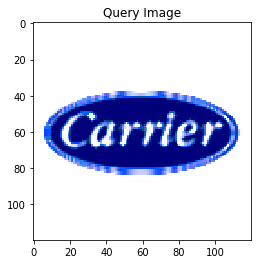

top 10 images in order are:  ['Mod-kraft', 'Mod-toyota-text', 'Mod-nissan-symbol', 'Mod-intel', 'Mod-audi-symbol', 'Mod-allianz-symbol', 'Mod-visa', 'Mod-honda-text', 'Mod-walmart', 'Mod-hyundai-symbol']


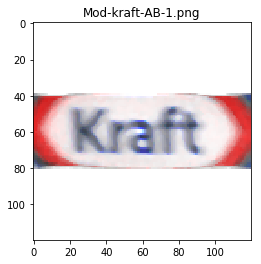

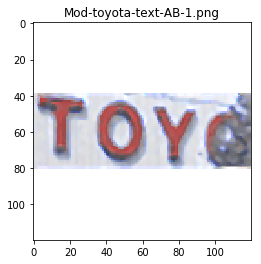

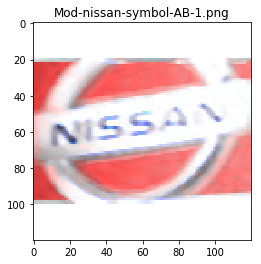

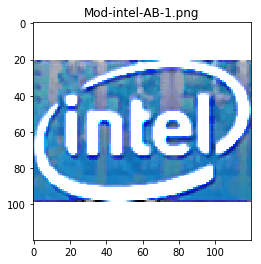

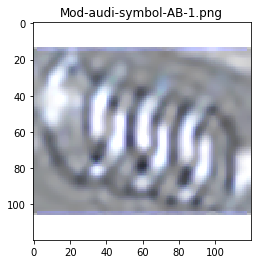

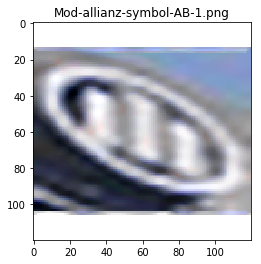

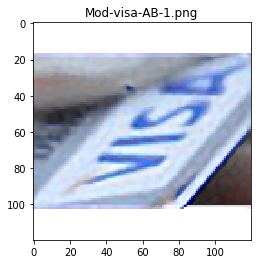

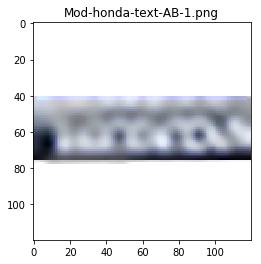

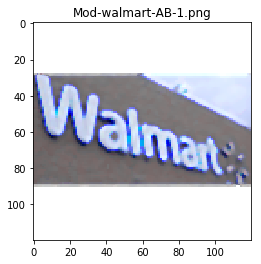

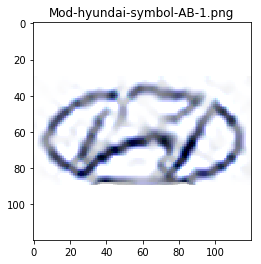

In [70]:
Get_average_score_ranking(df_average_score_list,df_folder_list,df_main_folder_path)

In [10]:
def Extract_query_img_feature(dir_litw,intermediate_layer_model):
    

    df_list=[]
    imageID=1
 
    index = 0
    X_train_row =[]
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    glob_path_complete_path=Path(dir_litw)
    file_name= os.listdir(glob_path_complete_path)
    file_name_full=os.path.join(glob_path_complete_path,file_name[0])
    
    img_original = mpimg.imread(file_name_full)
    normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
    logo_imgs_stage[index] = normalizedImg[:,:,:3]
    X_train_row.append(logo_imgs_stage)
    X_train=np.concatenate(X_train_row)
    feature_engg_data = intermediate_layer_model.predict(X_train)


    imageID = imageID+1
    return  feature_engg_data

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(query_feature, stored_feature):
    stored_feature = stored_feature.reshape(1, -1)
    
    query_feature = query_feature.reshape(1, -1)
    
    result=cosine_similarity(stored_feature,query_feature)
    #result = 1 - spatial.distance.cosine(stored_feature, query_feature)
    return result[0][0]

In [96]:
# Load dataset of logos in a dataframe
def extract_cosine_similarity_files(df_feature_list_indexed,query_feature,index_folder_count):
       
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1;
    
    brand_count_row=1
    total_rows=10
    folder_ave_score=0
    feature_vec=[]
   
    for index in range(total_rows):
            #feature_vector= map(lambda s: map(lambda f: float64(f), s[1:-1].split(',')), list(feature_vec))
            feature_vec=df_feature_list_indexed[index_folder_count]
            
            score_file = cosine_distance(query_feature,feature_vec.T)
            
            folder_ave_score = folder_ave_score+score_file
            print("index_folder_count from inside",index_folder_count)
            index_folder_count=index_folder_count+1
            brand_count_row=brand_count_row+1
    
    return folder_ave_score/total_rows   
           

In [97]:
def search_simlar_images(df_feature_list,df_file_list,df_folder_list,root_dir):
    
    query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")
    file_name= os.listdir(query_path)
    query_file_name_full=os.path.join(query_path,file_name[0])
    query_image = mpimg.imread((query_file_name_full))
    plt.title("query image")
    plt.imshow(query_image)
    plt.show()
    query_feature=Extract_query_img_feature(query_path)
    query_feature=query_feature/linalg.norm(query_feature)
    i_index_2=1
    scores=[]
    folder_path_global=root_dir
    index_folder_count=0
    start_row=0
    for company_name in df_folder_list:
        print(index_folder_count)
        scores.append(extract_cosine_similarity_files(df_feature_list,query_feature,index_folder_count)) # obtain average score per folder
        start_row=start_row+1
        index_folder_count=index_folder_count+10
        
    
    
    

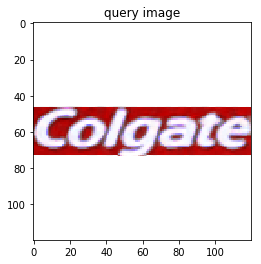

0
index_folder_count from inside 1
index_folder_count from inside 2
index_folder_count from inside 3
index_folder_count from inside 4
index_folder_count from inside 5
index_folder_count from inside 6
index_folder_count from inside 7
index_folder_count from inside 8
index_folder_count from inside 9
[0.45370245575904844]


TypeError: only integer scalar arrays can be converted to a scalar index

In [98]:
root_dir='c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_excluded_mscn2'
search_simlar_images(df_feature_list,df_file_list,df_folder_list,root_dir)

In [ ]:
from keras.models import Model
from PIL import Image, ImageOps,ImageFilter
import matplotlib.image as mpimg
import csv

def Get_Image_Features_bk():
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)

    dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_unique_images")

    df_list=[]
    folder_logo_num=0
    output = open('Features_file_logo_v1.csv', "w")
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    folders
    imageID=1
    for company_name in folders:
    #predict to get featured data
        glob_path_complete = (os.path.join(dir_litw,company_name))
        index = 0
        X_train_row =[]
        logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
        glob_path_complete_path=Path(glob_path_complete)
        file_name= os.listdir(glob_path_complete_path)
        file_name_full=os.path.join(glob_path_complete_path,file_name[0])
        img_original = mpimg.imread(file_name_full)

        normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
        logo_imgs_stage[index] = normalizedImg[:,:,:3]
        X_train_row.append(logo_imgs_stage)
        X_train=np.concatenate(X_train_row)
        feature_engg_data = intermediate_layer_model.predict(X_train)
        #print((feature_engg_data.flatten()))
        data=feature_engg_data.flatten()
        output.write(str(data))
        imageID = imageID+1
        
    output.close()  

In [ ]:
Get_Image_Features()


In [ ]:
def Extract_query_img_feature(dir_litw):
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)



    df_list=[]
    imageID=1
  

    index = 0
    X_train_row =[]
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    glob_path_complete_path=Path(dir_litw)
    file_name= os.listdir(glob_path_complete_path)
    file_name_full=os.path.join(glob_path_complete_path,file_name[0])
    print(file_name_full)
    img_original = mpimg.imread(file_name_full)

    normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
    logo_imgs_stage[index] = normalizedImg[:,:,:3]
    X_train_row.append(logo_imgs_stage)
    X_train=np.concatenate(X_train_row)
    feature_engg_data = intermediate_layer_model.predict(X_train)


    imageID = imageID+1
    return  feature_engg_data

In [ ]:
query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")
query_feature=Extract_query_img_feature(query_path)

In [ ]:
def Extract_test_img_feature(dir_litw):
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)

     

    df_list=[]
    imageID=1
  
    #predict to get featured data
    index = 0
    X_train_row =[]
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    glob_path_complete_path=Path(dir_litw)
    file_name= os.listdir(glob_path_complete_path)
    file_name_full=os.path.join(glob_path_complete_path,file_name[0])
    print(file_name_full)
    img_original = mpimg.imread(file_name_full)

    normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
    logo_imgs_stage[index] = normalizedImg[:,:,:3]
    X_train_row.append(logo_imgs_stage)
    X_train=np.concatenate(X_train_row)
    feature_engg_data = intermediate_layer_model.predict(X_train)
    print(feature_engg_data.shape)

    imageID = imageID+1
    return  feature_engg_data

In [ ]:
test_dir_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/cross_test")
test_features=Extract_test_img_feature(test_dir_path)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(stored_feature, query_feature):
    stored_feature = stored_feature.reshape(1, -1)
    query_feature = query_feature.reshape(1, -1)
    result=cosine_similarity(stored_feature,query_feature)
    #result = 1 - spatial.distance.cosine(stored_feature, query_feature)
    return result[0][0]

In [ ]:
d = cosine_distance(test_features, query_feature)

In [ ]:
print(d)

In [ ]:
test_features=Extract_test_img_feature()

In [ ]:
feature_engg_data=feature_engg_data.flatten()
results= Query_features(feature_engg_data,10)
print(results)

In [ ]:
# Get the count of images in each brand
def Get_brand_img_count(tp_df,threshold_count):
    # Plotn the graphs for demo
    print(str(tp_df.shape))
    print("X median",str(tp_df['X_size'].median()))
    print("X mean",str(tp_df['X_size'].mean()))

    print("Y median",str(tp_df['Y_size'].median()))
    print("Y mean",str(tp_df['Y_size'].mean()))
    tp_group_by=tp_df.groupby('company_brand').size().plot(kind='bar',color='green')
    plt.show()
    # Get image counts per brand
    tp_group_by_stage1=tp_df.groupby('company_brand').size()
    fp_series = pd.Series(tp_df['company_brand']).value_counts()
    plt.figure(figsize=(30, 30))
    fp_series[fp_series > threshold_count].plot.bar(color='limegreen')
    fp_series[fp_series > threshold_count].head()
    plt.rcParams.update({'font.size': 18})
    Count_brand_logos=(fp_series.values)
    print((Count_brand_logos))
    
    return Count_brand_logos, tp_df

In [ ]:
# Call counting and plotting functions for gathering dataset information
[Count_brand_logos,tp_df] = Get_brand_img_count(tp_df_image_resized,0)


In [ ]:
# select few samples from the company brands to evaluate the feasibility of the co-occurrence matrix
# Output: Input images X and their labels y
from skimage.feature import greycomatrix, greycoprops
from skimage import data,io
import matplotlib.image as mpimg

def Get_initial_data(df_filtered,Count_brand_logos):
    xs = []
    ys = []
    
    img_num = len(df_filtered) # number of distinct brands*num_of images_each_brand base don the threshold
    print(img_num)
    defect_imgs = np.ndarray((img_num, 120, 120), dtype=np.uint8)
    y = np.array(df_filtered['true_logo'],dtype=int)
    index = 0

    for index_df, record in df_filtered.iterrows():
        x = io.imread(record['logo_img_path'])
        red = x[:,:,2]
        green = x[:,:,1]
        blue = x[:,:,0]
        
        image_2D = x[:,:,3]
        
        #glcm = greycomatrix(nir,  [5], [0, np.pi/4, np.pi/2], levels=256, normed=True, symmetric=True)
        glcm = greycomatrix(image_2D,[5], [0], levels=256, symmetric=True, normed=True)
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        ys.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        index += 1
        X = defect_imgs        

    fig = plt.figure(figsize=(8, 8)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xs[:Count_brand_logos[0]], ys[:Count_brand_logos[0]], 'go',
        label='audi')
    ax.plot(xs[:Count_brand_logos[1]], ys[:Count_brand_logos[1]], 'bo',
        label='toyota')
    ax.plot(xs[:Count_brand_logos[2]], ys[:Count_brand_logos[2]], 'rs',
        label='mercedes')
    ax.set_xlabel('GLCM correlation',fontsize=28)
    ax.set_ylabel('GLCM dissimilarity',fontsize=28)
    ax.legend()
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='20') 
    plt.rcParams.update({'font.size': 28})
    return X,y    

In [ ]:
#Get all the images and labels
#Plot the similarity matrix
X,y = Get_initial_data(tp_df_image_resized,Count_brand_logos)

In [ ]:
import pickle
tp_df_image_resized.to_pickle('image_logos_folder_path.pkl')

In [ ]:
def get_train_test_df(df_image_total_brand_stage):

    logo_img_stage_count = len(df_image_total_brand_stage)            
    expected_dimension =120

    logo_imgs_stage = np.ndarray((logo_img_stage_count, 120, 120, 3), dtype=np.uint8)
    logo_img_orig_stage = np.ndarray((logo_img_stage_count, 120, 120, 4), dtype=np.uint8)
    y_stage = np.array(df_image_total_brand_stage['true_logo'])
    index=0
          
    for index_df, record in df_image_total_brand_stage.iterrows():
        
        # retrieve the image and feed it into mpimg.imread
        img_get = mpimg.imread(record['logo_img_path'])
        normalizedImg = cv2.normalize(img_get,None,0,1, cv2.NORM_MINMAX)
        logo_imgs_stage[index] = img_get[:,:,:3]

        img_orig = Image.open(record['original_image_name'])
        image_aspect=fix_aspect_ratio(img_orig,expected_dimension)
            
        img_resize_orig = make_square(image_aspect)
        logo_img_orig_stage[index]=img_resize_orig
        index += 1
    
       
    X_stage=logo_imgs_stage
    X_orig_stage=logo_img_orig_stage
    
    return X_stage, y_stage, X_orig_stage

In [ ]:
def Get_train_val_test_data_random(company_list,df_filtered):
    X_train_row =[]
    X_orig_train_row =[]
    X_val_row =[]
    X_orig_val_row =[]
    X_test_row=[]
    X_orig_test_row =[]
    y_train_row=[]
    y_val_row=[]
    y_test_row=[]

    for index_df, record in company_list.iterrows():
        df_image_total_brand = df_filtered[df_filtered['company_brand'] == record[0]]
        df_image_total_brand_train= df_image_total_brand.sample(110, replace=False, random_state=1)
        df_image_total_brand_test_validate = df_image_total_brand[~df_image_total_brand.index.isin(df_image_total_brand_train.index)]
        df_image_total_brand_validate = df_image_total_brand_test_validate.sample(20, replace=False, random_state=1)
        df_image_total_brand_test_inter = df_image_total_brand_test_validate[~df_image_total_brand_test_validate.index.isin(df_image_total_brand_validate.index)]
        df_image_total_brand_test = df_image_total_brand_test_inter.sample(20, replace=False, random_state=1)
        
        
        [X_train_inter,Y_train_inter,X_orig_train_inter]=get_train_test_df(df_image_total_brand_train)
        X_train_row.append(X_train_inter)
        y_train_row.append(Y_train_inter)
        X_orig_train_row.append(X_orig_train_inter)
        
        
        [X_val_inter,Y_val_inter,X_orig_val_inter]=get_train_test_df(df_image_total_brand_validate)
        X_val_row.append(X_val_inter)
        y_val_row.append(Y_val_inter)
        X_orig_val_row.append(X_orig_val_inter)
        
        [X_test_inter,Y_test_inter,X_orig_test_inter]=get_train_test_df(df_image_total_brand_test)
        X_test_row.append(X_test_inter)
        y_test_row.append(Y_test_inter)
        X_orig_test_row.append(X_orig_test_inter)
      
    X_train=np.concatenate(X_train_row)
    X_orig_train=np.concatenate(X_orig_train_row)
    y_train=np.concatenate(y_train_row)
    X_val=np.concatenate(X_val_row)
    X_orig_val=np.concatenate(X_orig_val_row)
    y_val=np.concatenate(y_val_row)
    X_test=np.concatenate(X_test_row)
    y_test=np.concatenate(y_test_row)
    X_orig_test=np.concatenate(X_orig_test_row)
    
    return X_train,y_train,X_val,y_val,X_test,y_test,X_orig_train,X_orig_val,X_orig_test

       

In [ ]:
import matplotlib.image as mpimg 
data = {'Company_brand':['hyundai-symbol','starbucks-symbol','mercedes','audi-symbol','bmw','toyota','target-symbol','allianz-symbol']} 

# Create DataFrame 
company_list = pd.DataFrame(data) 

[X_train,y_train,X_val,y_val,X_test,y_test,X_orig_train,X_orig_val,X_orig_test]=Get_train_val_test_data_random(company_list,df_filtered)



In [ ]:

print(y_val)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, nadam
from keras import backend as K
from keras.utils import to_categorical
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions_layer = Dense(8, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions_layer)
for layer in base_model.layers:
    layer.trainable = True
    


In [ ]:
model.summary()
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
y_test_1=np.array(y_test.astype(int64))   

In [ ]:
y_binary_train = to_categorical(y_train)
y_binary_valid = to_categorical(y_val)
y_binary_test=to_categorical(y_test)
model.fit((X_train), y_binary_train, shuffle=True, validation_data=((X_val), y_binary_valid), 
          batch_size=50, epochs=50, verbose=1, callbacks=[early_stopping])

In [ ]:
def print_predict_convert(X_test,y_test):

    predict_test_results = model.predict(X_test)
    
    predict_test_results


    # calculate accuracy
    y_predict = np.argmax(predict_test_results, axis=1)

    
    return(predict_test_results,y_test,y_test_1,y_predict)    

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def plot_confusion_mat(y_test_1,y_predict):

    cm = confusion_matrix(y_test_1, y_predict)
    print(cm)

    #plt.rcParams.update({'font.size': 28})
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['hyundai','starbucks','mercedes','audi','bmw','toyota','target','allianz'], yticklabels=['hyundai','starbucks','mercedes','audi','bmw','toyota','target','allianz'],cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
[predict_test_results,y_test,y_test_1,y_predict] = print_predict_convert(X_test,y_test)
plot_confusion_mat(y_test_1,y_predict)

In [ ]:
import sys
sys.getdefaultencoding()

In [ ]:
from keras.models import load_model
from joblib import dump, load
import pickle
from sklearn.cluster import KMeans

def save_model(model):
    s = pickle.dumps(model)
    dump(model, 'filename_22.joblib')
    Inception_feature_list=[]
    #model = load('filename_22.joblib') 
    #model.summary()
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)
    #predict to get featured data
    feature_engg_data = intermediate_layer_model.predict(X_test)
    feature_engg_data_inter = pd.DataFrame(feature_engg_data)
    print('feauture_engg_data shape:', feature_engg_data_inter.shape)
    return feature_engg_data_inter
    #features_arr = np.char.mod('%f', features)

    #plot_errors(pd_y_test_1,pd_y_predict,X_orig_test)
    #return feauture_engg_data

In [ ]:

feature_engg_data_inter = save_model(model)



In [ ]:
import csv

print(feature_engg_data_inter.shape)
feature_engg_data_inter_transpose =feature_engg_data_inter.T
#print(dir(feature_engg_data_inter))
feature_engg_data_inter_transpose.to_csv('feature_160images_1024.csv', sep='\t')

In [ ]:
from scipy.spatial.distance import cosine
from pandas import DataFrame

X_features = feature_engg_data_inter.to_numpy()
X_features_norm = preprocessing.normalize(X_features)
print( X_features_norm[0,:])
#prob_similarity = np.dot(X_features_norm[0,:],X_features_norm[1,:])
df = DataFrame({"col1": X_features_norm[0,:],
                "col2": X_features_norm[8,:]})

print(1 - cosine(df["col1"], df["col2"]))

#print(prob_similarity)
#prob_similarity_na = np.dot(X_features_norm[0,:],X_features_norm[158,:])
#print(prob_similarity_na)
#gmm = GaussianMixture(n_components=8).fit(X_features)
#proba = gmm.predict_proba(X_features)
#svm2 = SVC().fit(proba, y_test1)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(feature_engg_data_inter,y_test_1,
                     c=kmeans,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Features')
ax.set_ylabel('brand')
plt.colorbar(scatter)

In [ ]:


import numpy as np
import librosa
    
class MusicSearch:
    
    def __init__(self, training_files):
        self.frame_size = 4096
        self.hop_size = 4000
        self.fv_size = 12
        self.lsh = LSH(self.fv_size)
        self.training_files = training_files
        self.num_features_in_file = dict()
        for f in self.training_files:
            self.num_features_in_file[f] = 0
                
    def train(self):
        for filepath in self.training_files:
            x, fs = librosa.load(filepath)
            features = librosa.feature.chromagram(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
            self.lsh.add(features, filepath)
            self.num_features_in_file[filepath] += len(features)
                
    def query(self, filepath):
        x, fs = librosa.load(filepath)
        features = librosa.feature.chromagram(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
        results = self.lsh.query(features)
        print("num results", len(results))

        counts = dict()
        for r in results:
            if counts.has_key(r['label']):
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts
    


In [ ]:
class LSH:
    
    def __init__(self, dim):
        self.num_tables = 4
        self.hash_size = 8
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(self.hash_size, dim))
    
    def add(self, vecs, label):
        for table in self.tables:
            table.add(vecs, label)
    
    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

    def describe(self):
        for table in self.tables:
            print(table.table)

In [ ]:
class Table:
    
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.projections = randn(self.hash_size, dim)

    def add(self, vecs, label):
        entry = {'label': label}
        hashes = hash_func(vecs, self.projections)
        for h in hashes:
            if self.table.has_key(h):
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        hashes = hash_func(vecs, self.projections)
        results = list()
        for h in hashes:
            if self.table.has_key(h):
                results.extend(self.table[h])
        return results

In [ ]:
def hash_func(vecs, projections):
    bools = dot(vecs, projections.T) > 0
    return [bool2int(bool_vec) for bool_vec in bools]

In [ ]:
inception_feature_np_list=[]
inception_feature_np = np.array(feature_engg_data_inter)
print(inception_feature_np.shape)
inception_feature_np_list.append(inception_feature_np.flatten())
print(inception_feature_np.flatten().shape)
inception_feature_np_details = np.array(inception_feature_np_list)
print(inception_feature_np_details.shape)
kmeans = KMeans(n_clusters=1, random_state=0).fit(inception_feature_np_details)
print(X_test.shape)
kmeans.fit(X_test[0])


#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
def plot_errors(true, predict, X_test):
    
    correct_predictions = (true.values == predict.values)
    num_errors = len(np.where(correct_predictions == False)[0])
    print(num_errors)
    plot_index = 0
    plt.figure(figsize=(20, 10))
    num_columns = 10
    num_rows = math.ceil(num_errors / num_columns)
    for index, img in enumerate(X_test):
        if correct_predictions[index] == False:
                plt.subplot(num_columns,num_rows,plot_index+1)
                plt.title("Incorrect brand:")
                plt.imshow(X_test[index])
                plt.axis('off')
                plot_index += 1

In [ ]:
#act_columns=['Actual']
#print(y_test_1)
#print(y_predict)
#pd_y_test_1 =pd.DataFrame(y_test_1, columns=act_columns)
#predict_columns=['Predicted']

#pd_y_predict=pd.DataFrame(y_predict, columns=predict_columns)

features = model.predict(X_test)
Inception_feature_np = np.array(Inception_feature)
Inception_feature_list.append(Inception_feature_np.flatten())
        
Inception_feature_list_np = np.array(Inception_feature_list)
kmeans = KMeans(n_clusters=4, random_state=0).fit(Inception_feature_list_np)

features_arr = np.char.mod('%f', features)

plot_errors(pd_y_test_1,pd_y_predict,X_orig_test)

In [ ]:
from keras.models import load_model
from joblib import dump, load
import pickle

def save_model_repeat(model):
    s = pickle.dumps(model)
    dump(model, 'filename_9.joblib')

    #model = load('filename_8.joblib') 

    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)
    #predict to get featured data
    feauture_engg_data = intermediate_layer_model.predict(X_test)
    feauture_engg_data = pd.DataFrame(feauture_engg_data)
    print('feauture_engg_data shape:', feauture_engg_data.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def augument_data():
    datagen = ImageDataGenerator(rotation_range = 90, shear_range=0.2)
    datagen.fit(X_train)
    data_aug_dir='c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/aug_data'
    for x, val in zip(datagen.flow(X_train,                    
        save_to_dir=data_aug_dir,     
         save_prefix='mod',       
        save_format='png'),range(10)) :    
        pass
    batch_size = 40
    model.fit_generator(datagen.flow(X_train, y_binary_train, batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=50, verbose=1, 
                    shuffle=True, validation_data=(X_val, y_binary_valid), callbacks=[early_stopping])
    predict_test_augument = model.predict(X_test)
    y_predict_augument = np.argmax(predict_test_augument, axis=1)
    plot_confusion_mat(y_test_1,y_predict_augument)
    
    return y_predict_augument, model

In [ ]:
print("Resume")
[y_predict_augument, mode_repeat]=augument_data()

plot_errors(pd_y_test_1,y_predict_augument,X_orig_test)


In [ ]:
pd_y_test_1 =pd.DataFrame(y_test_1, columns=act_columns)
predict_columns=['Predicted']

pd_y_predict_augument=pd.DataFrame(y_predict_augument, columns=predict_columns)



plot_errors(pd_y_test_1,pd_y_predict_augument,X_orig_test)


In [ ]:
save_model_repeat(mode_repeat)

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('DiscoGAN.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
!python ./datasets/download.py edges2handbags

In [ ]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import SimpleITK as sitk
from IPython import display
from IPython.display import Image


In [ ]:
!python pix2pix2d.py --data_dir_A=/dli/data/nifti-png3ch/t1/ --data_dir_B=/dli/data/nifti-png3ch/seg/ --use_partial_data=True

In [ ]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=num_features, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(num_features, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [ ]:
#Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=num_features, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator

In [ ]:
num_features = df_filtered.shape[0]
def get_gan_network(discriminator, generator, optimizer,input_dim=num_features):

    discriminator.trainable = False   
    
    gan_input = Input(shape=(input_dim,))  
    
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [ ]:
print(num_features)

learning_rate = 0.00001
batch_size = 512
epochs = 10
adam = Adam(lr = learning_rate,beta_1 = 0.5)

In [ ]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import SimpleITK as sitk
from IPython import display
from IPython.display import Image
